# Modèle non linéaire - Accelerated Sinkhorn RNA

Ici on reprend tout ce qu'on a fait, mais on change la loss.
On utilise la distance de Wasserstein (transport optimal), calculé par un algorithme de Sinkorhn. 
On veut transpoter une distribution a en b.

We consider (for stabilization purpose)
the variables $f = \epsilon \log(u/a)$ and $g = \epsilon \log(v/b)$.
In these variables, Sinkhorn algorithm can be interpreted as an alternate maximization algorithm, to solve the following "dual" problem:
$$
\max_{f\in R^n, g \in R^m} F(f,g) =  \sum_{i=1}^n f_i a_i + \sum_{j=1}^m g_j b_j - \epsilon \sum_{i,j} a_ib_j \exp \left( (f_i + g_j -C_{ij})/\epsilon \right).
$$

In these variables, the algorithm is initialized with $g = 0_m$ and the updates read
$$
f_i \longleftarrow - \epsilon \log \sum_{j} b_j \exp ((g_j - C_{ij})/\epsilon),\, \forall i \\
g_j \longleftarrow - \epsilon \log \sum_{i} a_i \exp ((f_i - C_{ij})/\epsilon),\, \forall j
$$

The optimal transport plan $P=(P_{ij})_{\substack{i=1\dots n\\j=1\dots m}}$ can be recovered as 
$$
P_{ij} = a_ib_j\exp\left( (f_i+g_j - C_{ij})/\epsilon \right).
$$

On voit tout de suite une difficulté :

- The Gibbs kernel K is a Gaussian convolution,
$$ 
\begin{cases}
C_{i,j} = i/N-j/N)^2 , \\
 K_{i,j} = e^{ -(i/N-j/N)^2/\epsilon }, 
\end{cases}
 $$
et est indépendant de a et b

- Le coût final est 
$$ W = \langle P,C \rangle $$ 
la loss sera donc calculée à partir des dérivées des plan de transport u et v.
En effet
$$
\begin{split}
\frac{\partial W}{\partial a} = & \frac{\partial \langle P,C \rangle}{\partial a} \\ 
                = &  \langle\frac{\partial \text{exp} (-C_{ij} + u_i + v_j) / \epsilon) }{\partial a}, C \rangle \\
                = &  \langle\frac{\partial \text{exp} (u_i) / \epsilon) }{\partial a}, C \rangle 
                 + \langle\frac{\partial \text{exp} (v_j) / \epsilon) }{\partial a}, C \rangle \\
\end{split}
$$
Et donc à travers toutes les itérations... d'où le besoin d'accélérer l'algo.

## Importation

In [1]:
import numpy as np
# pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.modules.loss import _Loss
import torch
from torch.autograd import Variable
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [2]:
# Physical data
l = 1
tau = 1
dep = 1
# Numerical data
nx = 200
dx = l/(nx+1)
nt = 200
dt = tau/nt
T_operator = 1/100*dx*np.tri(nt, nx, 0, dtype=int)
# Data sample
nsamp = 400
x_dagger = np.zeros((nsamp,nx))
y = np.zeros((nsamp,nt))
x_grid = np.linspace(0,l,nx)
#
x_sample = np.zeros((nsamp,nx))
#
for i in range(0,nsamp):
    mu = l/2
    sigma = 10*l
    x_dagger[i] = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(x_grid-mu)**2/2*sigma**2)
    x_dagger[i] = x_dagger[i]/x_dagger[i].sum()
    y[i] = T_operator.dot(x_dagger[i]) 
    xi = np.random.uniform(-0.005,0.005,nt)
    y[i] += xi*np.linalg.norm(y[i])/np.linalg.norm(xi)
    x_sample[i] = np.transpose(T_operator).dot(y[i])

In [3]:
# Regularisation operator
D_operator = np.diag(np.ones(nx-1),1)+ np.diag(np.ones(nx-1),-1)-2*np.eye(nx)

In [4]:
x_tensor = torch.from_numpy(x_sample)
y_tensor = torch.from_numpy(x_dagger)

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [300, 100])

train_loader = DataLoader(dataset=train_dataset, batch_size=5)
val_loader = DataLoader(dataset=val_dataset, batch_size=5)

## Model

In [5]:
class MyModel(nn.Module):
    def __init__(self, number_of_layers, T, D, nx):
        super().__init__()
        self.alpha = [nn.Parameter(torch.ones(1), requires_grad=True)\
                      for k in range(number_of_layers)]
#         self.linear_output_transformation = nn.Linear(weight_dimensions, number_of_classes,\
#                                                       bias=False)
        self.activation_function = nn.Tanh()  
        self.activation_function_ter = nn.ReLU() 
        self.number_of_layers = number_of_layers
        # Physical model
        self.T = torch.from_numpy(np.transpose(T).dot(T))
        self.D = torch.from_numpy(np.transpose(D).dot(D))
        self.nx = nx
        
    
    def forward(self, x):
        y = torch.transpose(x,0,-1)
        for k in range(self.number_of_layers):
            tensor_grad = torch.eye(nx)\
              - self.T \
              - self.alpha[k]*self.D
            y = torch.matmul(tensor_grad,y)
            y = self.activation_function(y)
        y = self.activation_function_ter(y)
        y = y/torch.sum(y)
        return torch.transpose(y,0,-1)

In [6]:
model = MyModel(3,T_operator,D_operator,200)

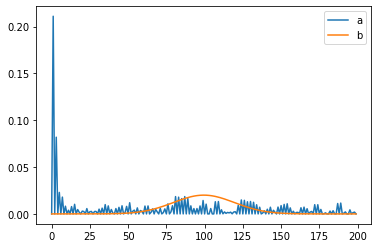

In [7]:
y_pred = model(train_dataset[0][0])
y_test = train_dataset[0][1]
plt.plot(y_pred.detach().numpy(),label="a")
plt.plot(y_test,label="b")
plt.legend()

## Loss

In [8]:
def sinkhorn_loss(a, b, epsilon, n, niter):
    """
    Given two emprical measures defined on a uniform grid xi = yi = i/n 
    (they are thue often refered to as "histograms"),
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    """

    # Definition of the cost matrix :
    t = np.linspace(0,1,n)
    [Y,X] = np.meshgrid(t,t)
    C_np = (X-Y)**2
    C = Variable(torch.from_numpy(C_np), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    tau = -.8  # nesterov-like acceleration
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations 
    # .....................................................................
    def ave(u, u1):
        "Over-relaxation to accelerate the convergence of the fixed-point algorithm." 
        "It consists in replacing the update by a linear combination of the new and previous iterate. "
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop 
    # ......................................................................
    f = torch.zeros_like(a)
    g = torch.zeros_like(a)
    actual_nits = 0 
    err = 0.

    for i in range(niter):
        f1 = f  # used to check the update error
        # Stable update u <- eps ( log a_i - log sum exp (-c_{ij} + f_i + g_j)/eps + f_i
        f = epsilon * (torch.log(a + 1e-6) - lse(M(f, g)).squeeze()) + f 
        # Stable update g <- eps ( log b_j - log sum exp (-c_{ij} + f_i + g_j)/eps + g_j
        g = epsilon * (torch.log(b + 1e-6) - lse(M(f,g).transpose(-2, -1)).squeeze()) + g
        # Error check
        err = (f - f1).abs().sum()
        actual_nits += 1
        if (err < thresh).data.numpy():
            break
            
    
    # Cost computatiom
    # ......................................................................
    F, G = f, g
    # Transport plan P_{ij} = a_i b_j exp (- C_{ij}+f_i+g_j )/\epsilon
    P = torch.exp(torch.log(a.unsqueeze(-1))+ torch.log(b.unsqueeze(-2)) + M(F, G))  
    # Sinkhorn cost
    cost = torch.sum(P * C)  

    return cost



In [9]:
class My_loss(_Loss):
    def __init__(self): 
        super(My_loss, self).__init__()
        self.epsilon = 0.1
        self.n = 200
        self.niter = 10
 
    def forward(self, output, target):
        computed_loss = sinkhorn_loss(output, target, self.epsilon, self.n, self.niter)
        return computed_loss

In [10]:
loss_fn = My_loss()

In [11]:
y_pred = model(train_dataset[0][0])
y_test = train_dataset[12][1]

In [12]:
loss_fn(y_pred, y_test)

tensor(0.0002, dtype=torch.float64, grad_fn=<SumBackward0>)

## Training

In [13]:
lr = 1e-1
# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.alpha, lr=lr)

In [14]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        y_pred = model(x)
        # Computes loss
        loss = loss_fn(y_pred,y)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [15]:
# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

In [16]:
losses = []
val_losses = []
n_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(n_epochs):
    
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

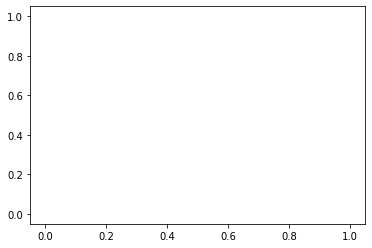

In [17]:
plt.plot(val_losses)